# Deep Learning Tweet Analytics

Your name: Rohit Govindan
Your Andrew ID:rohitgov
Collaborators (if none, say \"none\"; do *not* leave this blank): none

# Part 1: Email spam classification [25 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [1]:
#Can be improved
import glob
ham_count = 0
spam_count = 0
for file in glob.glob(r"./email-data/ham/*.txt"):
    ham_count+=1
    
for file in glob.glob(r"./email-data/spam/*.txt"):
    spam_count+=1


print("Number of Ham Emails are: " + str(ham_count))
print("Number of Spam Emails are: " + str(spam_count))

Number of Ham Emails are: 0
Number of Spam Emails are: 0


The dataset does seem to be have a minor imbalance with Ham emails being 29% and Spam around 71%. However this imbalance is not as skewed as we see in Fraud/Cancer detection where one class is only 1-5% and is mild imbalance.

If it was extremenly imbalanced, it would have been problematic. In that case, we could do undersampling of the majority class or oversampling of the minority class. A popoular oversampling technique is SMOTE. 

**Your answers to the above questions:**

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [2]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
#Kept seperate to not pick up testing - Can be fixed with checks inside one loop
ham_emails = []
spam_emails = []
for file in glob.glob(r"./email-data/ham/*.txt"):
    ham_emails.append(make_word_list(file))
    
for file in glob.glob(r"./email-data/spam/*.txt"):
    spam_emails.append(make_word_list(file))

processed_docs = ham_emails + spam_emails
doc_labels = [0]*len(ham_emails) + [1]*len(spam_emails) 

**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [4]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')
X = tf_vectorizer.fit_transform(processed_docs)
vocab = tf_vectorizer.vocabulary_
print("The number of unique words in the vocabulary are: " + str(len(vocab)))

The number of unique words in the vocabulary are: 1680


**(d) k-NN and random forest: Hyperparameter selection [5 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [5]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np 

num_folds = 5
k_fold = KFold(num_folds,shuffle = True, random_state=0)
hyperparameter_settings = [k  for k in range(1,16)]  # fill this with hyperparameter settings that you want to try

X_arr = X.toarray()
labels_arr = np.array(doc_labels)
best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    for train_indexes, val_indexes in k_fold.split(X_arr):
        
        train_features = X_arr[train_indexes]
        train_labels = labels_arr[train_indexes]
        val_features = X_arr[val_indexes]
        val_labels = labels_arr[val_indexes]
        
        model = KNeighborsClassifier(n_neighbors=hyperparam_setting)
        model.fit(train_features,train_labels)
        predicted_val_labels  = model.predict(val_features)
        fold_scores.append(f1_score(val_labels,predicted_val_labels,average='weighted'))
        
    cross_val_score = np.mean(fold_scores)
    print('k:', hyperparam_setting, 'f1_score', cross_val_score)
    
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

best_k = best_hyperparam_setting
print('Best hyperparameter setting: k =', best_hyperparam_setting)

k: 1 f1_score 0.9318548593700239
k: 2 f1_score 0.9136536625237305
k: 3 f1_score 0.9468202559285755
k: 4 f1_score 0.9288892298413135
k: 5 f1_score 0.9102261971507989
k: 6 f1_score 0.9162818009667468
k: 7 f1_score 0.9005957912198788
k: 8 f1_score 0.9084880515524754
k: 9 f1_score 0.8918825345203863
k: 10 f1_score 0.8978202504763132
k: 11 f1_score 0.8814988836034496
k: 12 f1_score 0.890606008606475
k: 13 f1_score 0.8776166817099419
k: 14 f1_score 0.8850481898657006
k: 15 f1_score 0.8724955455716668
Best hyperparameter setting: k = 3


In [6]:
from sklearn.ensemble import RandomForestClassifier
num_folds = 5
k_fold = KFold(num_folds,shuffle = True, random_state=0)
num_features = X_arr.shape[1]

hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 6)),
                                                int(np.ceil(np.sqrt(num_features) / 3)),
                                                int(np.ceil(np.sqrt(num_features))), #Auto value for sklearn
                                                int(np.ceil(np.sqrt(num_features) * 3))]
                           for min_samples_leaf in [1, 2, 4, 8]]  

# fill this with hyperparameter settings that you want to try

X_arr = X.toarray()
labels_arr = np.array(doc_labels)
best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    max_features, min_samples_leaf = hyperparam_setting
    # your code to train and score the training data here
    for train_indexes, val_indexes in k_fold.split(X_arr):
        
        train_features = X_arr[train_indexes]
        train_labels = labels_arr[train_indexes]
        val_features = X_arr[val_indexes]
        val_labels = labels_arr[val_indexes]
        
        model = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        model.fit(train_features,train_labels)
        predicted_val_labels  = model.predict(val_features)
        fold_scores.append(f1_score(val_labels,predicted_val_labels,average='weighted'))
        
    cross_val_score = np.mean(fold_scores)
    print('Hyperparameter:', hyperparam_setting, 'f1_score', cross_val_score)
    
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

best_max_features,best_min_samples_leaf = best_hyperparam_setting
print('Best hyperparameter setting (max_features,min_samples_leaf): ', best_hyperparam_setting)

Hyperparameter: (7, 1) f1_score 0.9887263035733209
Hyperparameter: (7, 2) f1_score 0.9758778484776476
Hyperparameter: (7, 4) f1_score 0.9591978453103535
Hyperparameter: (7, 8) f1_score 0.9363234528864265
Hyperparameter: (14, 1) f1_score 0.9899040023122053
Hyperparameter: (14, 2) f1_score 0.9849942448813168
Hyperparameter: (14, 4) f1_score 0.9757007874576512
Hyperparameter: (14, 8) f1_score 0.9624745366652624
Hyperparameter: (41, 1) f1_score 0.988568013213186
Hyperparameter: (41, 2) f1_score 0.9840407496716704
Hyperparameter: (41, 4) f1_score 0.9814661063271863
Hyperparameter: (41, 8) f1_score 0.9737394649254723
Hyperparameter: (123, 1) f1_score 0.9819839065768836
Hyperparameter: (123, 2) f1_score 0.9809817521366554
Hyperparameter: (123, 4) f1_score 0.976823789037978
Hyperparameter: (123, 8) f1_score 0.9716683656570357
Best hyperparameter setting (max_features,min_samples_leaf):  (14, 1)


**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [7]:
test_emails = []
test_labels = []
for file in glob.glob(r"./email-data/testing/*.txt"):
    test_emails.append(make_word_list(file))
    if '.spam.' in file:
        test_labels.append(1)
    else:
        test_labels.append(0)
        
X_test = tf_vectorizer.transform(test_emails)
test_labels = np.array(test_labels)

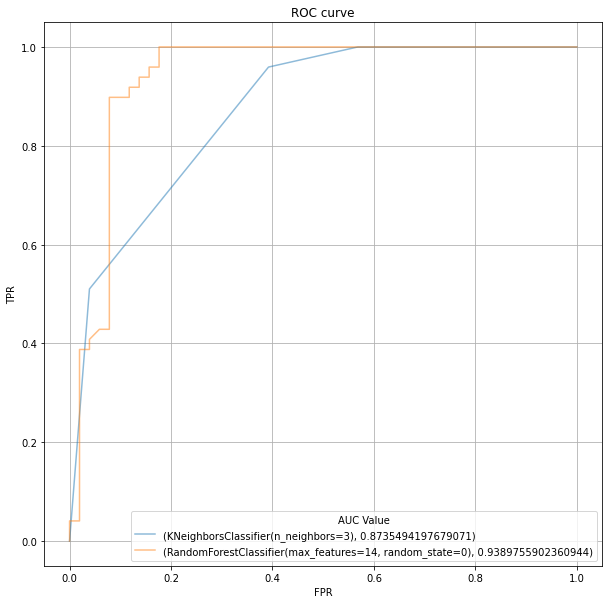

In [8]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
final_rf = RandomForestClassifier(max_features=best_max_features,
                                            min_samples_leaf=best_min_samples_leaf,
                                            random_state=0)

models = [final_knn_classifier,final_rf]
colors = ["C0", "C1"]

plt.figure(figsize=(10,10))
for i,model in enumerate(models):
    model.fit(X_arr, labels_arr)
    predicted_test_labels = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] #probabilistic classifier, so the model outputs probabilities
    fpr, tpr, thresholds = roc_curve(test_labels, y_score, pos_label=1)
    auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= colors[i], label = (model,auc))

plt.title("ROC curve")
plt.legend(title = "AUC Value", loc = "best")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()


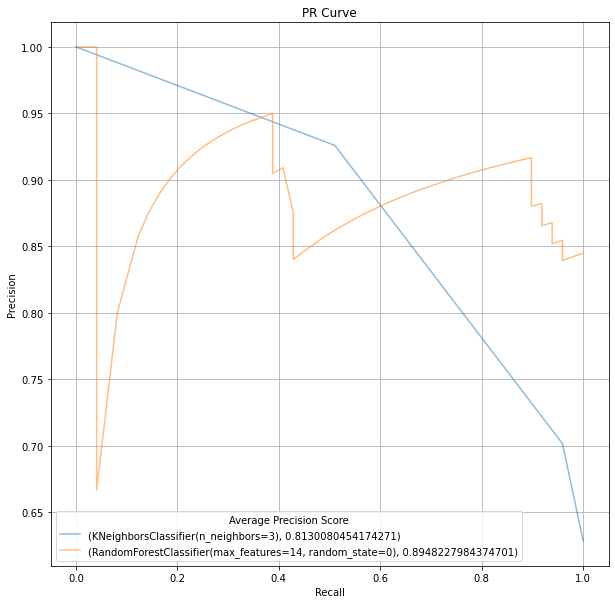

In [9]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10,10))
for i,model in enumerate(models):
    model.fit(X_arr, labels_arr)
    predicted_test_labels = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] #probabilistic classifier, so the model outputs probabilities
    precision, recall, thresholds = precision_recall_curve(test_labels, y_score, pos_label=1)
#     auc = np.trapz(tpr, fpr)
    aps = average_precision_score(test_labels, y_score, pos_label=1)
    plt.plot(recall,precision, linestyle='-', alpha=0.5, color= colors[i], label = (model,aps))

plt.title("PR Curve")
plt.legend(title = "Average Precision Score", loc = "best")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()


**Your answers to the above questions:**

As the data has imbalance, the ROC curve estimates will be unreliable and might give overly optimistic view of the performance of the model (focusing on both classes). The PR curve on the other hand focuses on the minority class as is evident by comparing Precision vs Recall and might be better to use in our case. 
Using the PR curve, I would select Random Forest Classifier as the better classifier of the two. (Area under the PR curve is higher at 0.89 )

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

C:\Users\nahse\AppData\Local\Temp/ipykernel_4164/3756618938.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


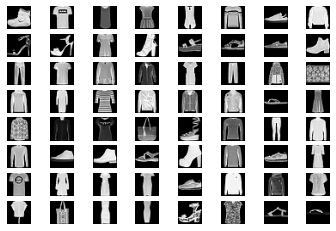

In [11]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [12]:
x_train = train_images[torch.where((train_labels == 2)|(train_labels == 6))]
x_test = test_images[torch.where((test_labels == 2)|(test_labels == 6))]

y_train = train_labels[torch.where((train_labels == 2)|(train_labels == 6))]
y_test = test_labels[torch.where((test_labels == 2)|(test_labels == 6))]

y_train = torch.tensor([0 if val == 2 else 1 for val in y_train])
y_test = torch.tensor([0 if val == 2 else 1 for val in y_test])

In [13]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [14]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [15]:
# write your code here
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [16]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))

# Added map_location CPU to run on just CPU
convnet.load_state_dict(torch.load('pretrained_convnet.pt',map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

C:\Users\nahse\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()
C:\Users\nahse\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [17]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.046539
[t-SNE] KL divergence after 1000 iterations: 1.063490


(-53.22366809844971, 49.30532932281494, -52.25156841278076, 39.629898643493654)

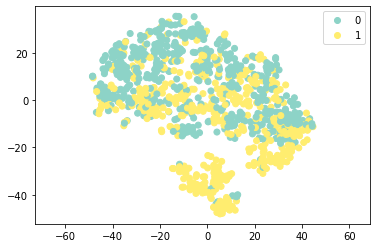

In [18]:
# write your code here
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=25) 
raw_tsne = tsne.fit_transform(x_train_small[:,0].reshape(len(x_train_small),-1).detach().numpy())

scatter = plt.scatter(raw_tsne[:, 0],
            raw_tsne[:, 1],
            c=y_train_small, cmap='Set3')
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1])
plt.axis('equal')

C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\nahse\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.261436
[t-SNE] KL divergence after 1000 iterations: 0.991353


(-56.05586757659912, 37.10888805389404, -51.56147785186768, 40.511074256896975)

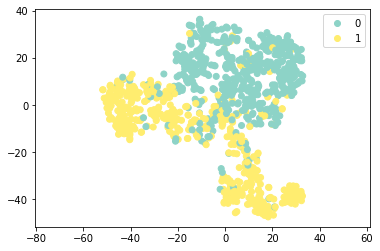

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=25) 
bottle_tsne = tsne.fit_transform(x_train_small_bottleneck_representation.detach().numpy())

scatter = plt.scatter(bottle_tsne[:, 0],
            bottle_tsne[:, 1],
            c=y_train_small, cmap='Set3')
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1])
plt.axis('equal')

In [20]:
x_train_small_bottleneck_representation.shape

torch.Size([1000, 84])

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |                     | this cell stays empty|
| 5-NN             |                     |                      |
| Random forest    |                     |                      |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [21]:
# Pretrained CNN test
output = UDA_pytorch_model_transform(convnet,x_test)
y_pred_labels = output[:,[2,6]].argmax(axis=1).view(-1)
print('Test accuracy:', UDA_compute_accuracy(y_pred_labels, y_test))

Test accuracy: 0.891


In [22]:
def model_eval(model,x_train_arr,y_train_arr,x_test_arr,y_test_arr):
    modelfit = model.fit(x_train_arr,y_train_arr)
    y_pred_labels = modelfit.predict(x_test_arr)
    
    accuracy = accuracy_score(y_test_arr,y_pred_labels)
    print('Test accuracy is: ',accuracy)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 5NN on all training examples
x_train_raw = x_train[:,0].reshape(len(x_train),-1).detach().numpy()
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_flat = x_test[:,0].reshape(len(x_test),-1).detach().numpy()
x_test_bottleneck_rep=  UDA_pytorch_model_transform(intermediate_layer_model, x_test)

print("5NN on Raw Data")
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model_eval(knn,x_train_raw,y_train,x_test_flat,y_test)

print("\n 5NN on Bottleneck Data")
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model_eval(knn,x_train_bottleneck_representation,y_train,x_test_bottleneck_rep,y_test)

print("\n Random Forest Classifier on Raw Data")
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
model_eval(rf,x_train_raw,y_train,x_test_flat,y_test)

print("\n Random Forest Classifier on Bottleneck Data")
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
model_eval(rf,x_train_bottleneck_representation,y_train,x_test_bottleneck_rep,y_test)

5NN on Raw Data
Test accuracy is:  0.856

 5NN on Bottleneck Data
Test accuracy is:  0.888

 Random Forest Classifier on Raw Data
Test accuracy is:  0.8765

 Random Forest Classifier on Bottleneck Data
Test accuracy is:  0.898


| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |      0.891          | this cell stays empty|
| 5-NN             |      0.856          |      0.888           |
| Random forest    |      0.8765         |      0.898           |

Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 5-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:**

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'TPR')

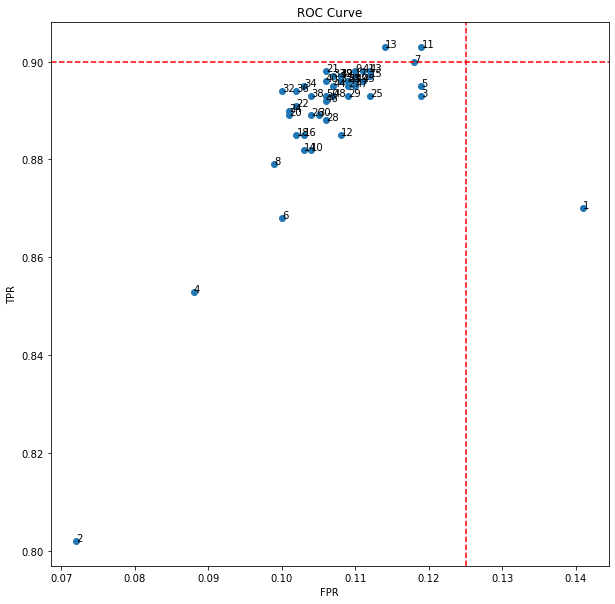

In [24]:
# write your code here
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

ks = np.arange(1,51)
fpr_l = []
tpr_l = []

from tqdm.notebook import tqdm_notebook
for k in tqdm_notebook(ks):
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    modelfit = knn.fit(x_train_bottleneck_representation,y_train)
    y_pred_labels = modelfit.predict(x_test_bottleneck_rep)
#     y_score = modelfit.predict_proba(x_test_bottleneck_rep)[:,1]
#     fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    cm=confusion_matrix(y_test, y_pred_labels)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    fpr_l.append(fpr)
    tpr_l.append(tpr)

plt.figure(figsize=(10,10))
plt.scatter(fpr_l, tpr_l)

for i,k in enumerate(ks):
    plt.annotate(k,(fpr_l[i],tpr_l[i]))
    
plt.title("ROC Curve")
plt.axvline(x=0.125,color='r',linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:**

Based on the requirements of the company, an ideal k would be k=13 as it has the highest TPR (tied with k=11) but has an FPR that is lower. 

# Part 3: Sentiment Analysis [35 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.** We will give full credit even if you subsample the training data. For example, you only work with 5000 randomly chosen training tweets instead of all of them (over 1 million tweets). Also, for the random forest part (the last part), you can keep track of only the most frequently occurring 1000 words (again, this is enough for full credit) and you can also set the RandomForestClassifier argument "n_jobs" to -1 to use all your CPU threads. However, do not subsample the test dataset (which is small anyways).

If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures). Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions:

- Using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

- For the last part, training a random forest for sentiment analysis could be very computationally expensive. If you are already subsampling the training data beforehand, then great, just work with a smaller dataset (note: you should use the same training data for both the LSTM and for the random forest so that the comparison between them is fair). If you want to still try to use the full training dataset or as much of it as possible, then we suggest that you represent the feature vectors as a sparse matrix. You might also want to set the "max_samples" argument to be something like 0.1 so that each tree uses a 10% subsample of the proper training set (with the default choice of 100 trees, across all your trees, you will likely use the vast majority of the full training set---it's just that each tree won't look at more than 10% of the proper training set). Also, simple data splitting suffices; cross-validation here would be very expensive. Moreover, it's fine to not train a random forest from scratch using the best hyperparameters found; instead just use whichever model was trained using the proper training data with the best hyperparameters found.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [25]:
# your code here
import pandas as pd

train = pd.read_csv('./HW3-data/train.csv',encoding='iso8859',header=None)
train = train.drop(columns=[1,2,3,4])
train_arr = train.values
print("0 corresponds to Negative Sentiments & 1 corresponds to Positive sentiments")
print(train[0].value_counts())

0 corresponds to Negative Sentiments & 1 corresponds to Positive sentiments
0    800000
1    800000
Name: 0, dtype: int64


In [26]:
from random import sample
train_arr_small = np.array(sample(list(train_arr),20000))
print("Negative Tweets in Sampled Training Data: ",len(train_arr_small[train_arr_small[:,0] == 0]))
print("Positive Tweets in Sampled Training Data: ",len(train_arr_small[train_arr_small[:,0] == 1]))

Negative Tweets in Sampled Training Data:  10077
Positive Tweets in Sampled Training Data:  9923


**(b) [20 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [27]:
# your code here
proper_train_size = int(len(train_arr_small) * 0.8)
val_size = len(train_arr_small) - proper_train_size
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_arr_small,
                                                                  [proper_train_size,
                                                                   val_size])

In [28]:
from torchnlp.encoders.text import SpacyEncoder
encoder = SpacyEncoder([data[1] for data in proper_train_dataset])
proper_train_encoded = [encoder.encode(data[1]) for data in proper_train_dataset]

In [29]:
print(proper_train_dataset[1])
print(proper_train_encoded[1])
print([encoder.vocab[word_idx] for word_idx in proper_train_encoded[1]])

[1
 '@laurajdavis Do not complain - the sun will go away!  I really it want it to stay for the next 3 months!!! ']
tensor([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 25, 27,
        28, 29, 16, 30, 31, 32, 21, 21, 21])
['@laurajdavis', 'Do', 'not', 'complain', '-', 'the', 'sun', 'will', 'go', 'away', '!', ' ', 'I', 'really', 'it', 'want', 'it', 'to', 'stay', 'for', 'the', 'next', '3', 'months', '!', '!', '!']


In [30]:
proper_train_labels = torch.tensor([data[0] for data in proper_train_dataset])
val_encoded = [encoder.encode(data[1]) for data in val_dataset]
val_labels = torch.tensor([data[0] for data in val_dataset])
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

In [31]:
# SpacyEncoder by default has <unk> implemented
encoder.vocab[:5]

['<pad>', '<unk>', '</s>', '<s>', '<copy>']

In [32]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [33]:
embedding_weights = torch.empty(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [34]:
from UDA_pytorch_utils import UDA_LSTMforSequential
simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 31688]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          3.211426M
Trainable params        42.626k
Non-trainable params    3.1688M
Mult-Adds               42.112k


C:\Users\nahse\anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 31688]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


In [35]:
import os
os.makedirs('./saved_model_checkpoints', exist_ok=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Learning Rate used:  0.01
Batch Size used:  64
Epoch 1 [==================================================] 16000/16000
  Train accuracy: 0.5534
  Validation accuracy: 0.5500
Epoch 2 [==================================================] 16000/16000
  Train accuracy: 0.5772
  Validation accuracy: 0.5707
Epoch 3 [==================================================] 16000/16000
  Train accuracy: 0.7053
  Validation accuracy: 0.6845
Epoch 4 [==================================================] 16000/16000
  Train accuracy: 0.7514
  Validation accuracy: 0.7177
Epoch 5 [==================================================] 16000/16000
  Train accuracy: 0.7204
  Validation accuracy: 0.6770
Epoch 6 [==================================================] 16000/16000
  Train accuracy: 0.7558
  Validation accuracy: 0.6923
Epoch 7 [==================================================] 16000/16000
  Train accuracy: 0.7577
  Validation accuracy: 0.6887
Epoch 8 [================================================

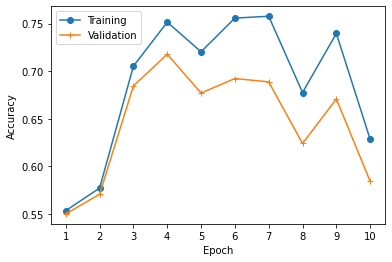

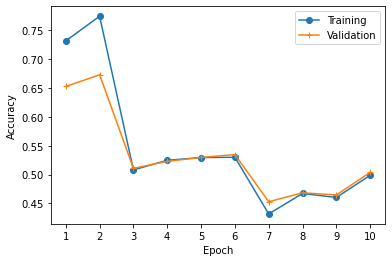

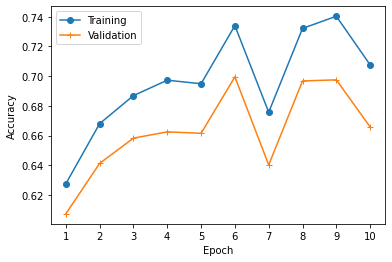

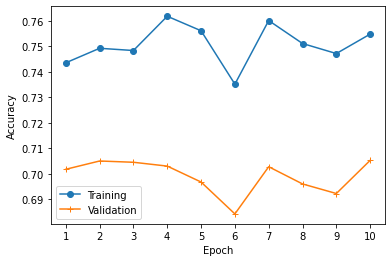

In [36]:
num_epochs = 10  # during optimization, how many times we look at training data
# batch_size = 64  # during optimization, how many training data to use at each step
# learning_rate = [0.1,0.05]  # during optimization, how much we nudge our solution at each step


hyperparameter_settings = [(learning_rate, batch_size)
                           for learning_rate in [0.01,0.05]
                           for batch_size in [64,128]]  

best_val_acc = -np.inf  # assumes that a higher score is better
best_epoch = None
best_hp = None
from tqdm.notebook import tqdm_notebook
for hp_set in tqdm_notebook(hyperparameter_settings):
    lr,bs = hp_set
    print("=========================")
    print("Learning Rate used: ",lr)
    print("Batch Size used: ",bs)
    train_accuracies, val_accuracies = \
        UDA_pytorch_classifier_fit(simple_lstm_model,
                                   torch.optim.Adam(simple_lstm_model.parameters(),
                                                    lr=lr),
                                   nn.CrossEntropyLoss(),  # includes softmax
                                   proper_train_dataset_encoded, val_dataset_encoded,
                                   num_epochs, bs,
                                   sequence=True,
                                   save_epoch_checkpoint_prefix='./saved_model_checkpoints/twitter_lstm_{}'.format(hp_set))

    best_epoch_idx = np.argmax(val_accuracies)
    print('The model at the end of epoch %d achieved the highest validation accuracy: %f'
          % (best_epoch_idx + 1, val_accuracies[best_epoch_idx]))
    
    if val_accuracies[best_epoch_idx] > best_val_acc:
        best_val_acc = val_accuracies[best_epoch_idx]
        best_hp = hp_set
        best_epoch = best_epoch_idx+1

    UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [37]:
print("The model with parameters (learnig_rate,batch_size) as {} \n at the end of epoch {} achieved the highest validation accuracy: {}.".
      format(best_hp,best_epoch,best_val_acc))
simple_lstm_model.load_state_dict(torch.load('./saved_model_checkpoints/twitter_lstm_{}_epoch{}.pt'.
                                             format(best_hp,best_epoch)))

The model with parameters (learnig_rate,batch_size) as (0.01, 64) 
 at the end of epoch 4 achieved the highest validation accuracy: 0.71775.


<All keys matched successfully>

In [38]:
test = pd.read_csv('./HW3-data/test.csv',encoding='iso8859',header=None)
test = test.drop(columns=[1,2,3,4])
test_arr = test.values

In [39]:
test_encoded = [encoder.encode(data[1]) for data in test_arr]
test_labels = torch.tensor([data[0] for data in test_arr])

In [40]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.5542168674698795


**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Not combining Proper Training and Validation as given in instructions and because Proper Train is a big enough sample. 
# That is what the LSTM was trained on as well and would remain the same for comparision
encoder_vocabdict = {val:idx for idx,val in enumerate(encoder.vocab)}
proper_train_encoded_str = [" ".join(map(str,tweet.numpy().tolist())) for tweet in proper_train_encoded]

tf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8,vocabulary=encoder_vocabdict,lowercase=False)
X_encoded_tf = tf_vectorizer.fit_transform(proper_train_encoded_str)
# vocab = list(tf_vectorizer.vocabulary_.keys())
tf_vocab = tf_vectorizer.vocabulary_

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
#     'max_depth': [5, 20,None],
    'max_features': ["auto", 0.25,0.5],
    'min_samples_leaf': [1,10]}
    
rfc = RandomForestClassifier(random_state=0)
    
grid_search=GridSearchCV(rfc,param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=2)
    
grid_search.fit(X_encoded_tf,proper_train_labels)

print("The best Hyperparameter setting for RFC with CV accuracy {} is: {}".format(grid_search.best_score_,
      grid_search.best_params_))
rfc = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best Hyperparameter setting for RFC with CV accuracy 0.599 is: {'max_features': 0.25, 'min_samples_leaf': 10}


In [48]:
test_encoded_str = [" ".join(map(str,tweet.numpy().tolist())) for tweet in test_encoded]
test_encoded_str_tf = tf_vectorizer.transform(test_encoded_str)
rfc_pred = rfc.predict(test_encoded_str_tf)
print('Test accuracy for Random Forest Classifier:', accuracy_score(test_labels,rfc_pred))

Test accuracy for Random Forest Classifier: 0.4959839357429719


The test accuracy with the Baseline Random Forest Classifier was worse than the LSTM but not by a big margin. The Test accuracy of the LSTM was 55.4% as compared to the 49.6% accuracy of the RFC. I would hope that with more data, the LSTM is able to learn more and perform better. ( An earlier run with 60000 data points had given a Test Accuracy of 60% for the LSTM )